<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4
*Pick one of the examples of the chapter that use the data of the book and replicate it in Python. Then, apply the steps in your own data.*

Los datos utilizados en este cuaderno están disponibles aquí: [datasets](https://drive.google.com/drive/folders/159GnBJQDxTY9oYqPBZzdNghyb4Gd9pDS?usp=sharing)

In [2365]:
from ssl import OP_SINGLE_DH_USE
import numpy as np
import pandas as pd
import itertools
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,confusion_matrix, accuracy_score, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import linalg
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.tools.eval_measures as bias
import seaborn as sns
warnings.filterwarnings("ignore")
%matplotlib inline

## Regresión logística en predicción de enfermedades cardiacas
A continuación repetiremos el ejemplo 4.4.2 de predicción de enfermedad cardiaca en Sudafrica **(South African Heart Disease)** del [libro](https://link.springer.com/book/10.1007/978-0-387-84858-7).

Iniciamos cargando los datos de entrenamiento y almacenamos en `y_train`:

In [2366]:
## Procesamos datos de entrenamiento 
df = pd.read_csv('SAheart.csv')
df=df.assign(const=1)
print(df)
dfy = df['chd'] 
dfx = df[['const','sbp','tobacco','ldl','adiposity','famhist','obesity','alcohol','age']]  ## Predictors

## Procesamos datos de prueba 
dfyt = df['chd'] 
dfxt = df[['const','sbp','tobacco','ldl','adiposity','famhist','obesity','alcohol','age']]  ## Predictors

     row.names  sbp  tobacco    ldl  ...  alcohol  age  chd  const
0            1  160    12.00   5.73  ...    97.20   52    1      1
1            2  144     0.01   4.41  ...     2.06   63    1      1
2            3  118     0.08   3.48  ...     3.81   46    0      1
3            4  170     7.50   6.41  ...    24.26   58    1      1
4            5  134    13.60   3.50  ...    57.34   49    1      1
..         ...  ...      ...    ...  ...      ...  ...  ...    ...
457        459  214     0.40   5.98  ...     0.00   58    0      1
458        460  182     4.20   4.41  ...    18.72   52    1      1
459        461  108     3.00   1.59  ...    26.64   55    0      1
460        462  118     5.40  11.61  ...    23.97   40    0      1
461        463  132     0.00   4.82  ...     0.00   46    1      1

[462 rows x 12 columns]


In [2367]:
X_train = dfx.to_numpy()   
X_train = sm.add_constant(X_train)
y_train = dfy.to_numpy()  
X_test  = dfxt.to_numpy()   
X_test = sm.add_constant(X_train)
y_test  = dfyt.to_numpy()   
#X_train.tofile('sample.csv',sep=',')

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión logística de la librería **statsmodels**. Como podemos ver algunas de las variables resultan ser no significativas con un valor P menor que 0.05. Tal es el caso de *alcohol, obesity, adiposity* y *sbp*. 

In [2368]:
model = sm.Logit(dfy, dfx)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.522778
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      453
Method:                           MLE   Df Model:                            8
Date:                Sun, 30 Jan 2022   Pseudo R-squ.:                  0.1897
Time:                        05:42:37   Log-Likelihood:                -241.52
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 8.931e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9658      1.068     -3.715      0.000      -6.058      -1.873
sbp            0.0056      0.

De acuerdo con el libro, se aplicó una técnica de reducción de variables paso a paso **(Stepwise)** en el se encuentra un subconjunto de las variables que son suficientes para explicar el efecto conjunto de los predictores sobre la variable *chd*. El procedimiento descarta el coeficiente P menos significativo `pmenor` y el modelo se reajusta. Esto se hace repetidamente hasta que no se puedan eliminar más variables del modelo.
Los resultados obtenidos en la tabla coinciden con los del libro.


In [2369]:
# Se ordenan los valores p y se selecciona el más pequeño
p_values = results.pvalues.sort_values(ascending = False)
pmenor = p_values.head(1)

print("menorpi.item() ", pmenor.item())

## Proceso de stepwise
while pmenor.item() > 0.01:
    print(pmenor.index.tolist())
    dfx = dfx.drop(pmenor.index.tolist(), axis=1)
    model = sm.Logit(dfy, dfx)
    model = model.fit()
    # Se ordenan los valores p y se selecciona el más pequeño
    p_values = model.pvalues.sort_values(ascending = False)
    pmenor = p_values.head(1)

print(model.summary())

menorpi.item()  0.9062256410652616
['alcohol']
Optimization terminated successfully.
         Current function value: 0.522793
         Iterations 6
['adiposity']
Optimization terminated successfully.
         Current function value: 0.522936
         Iterations 6
['sbp']
Optimization terminated successfully.
         Current function value: 0.524131
         Iterations 6
['obesity']
Optimization terminated successfully.
         Current function value: 0.525372
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      457
Method:                           MLE   Df Model:                            4
Date:                Sun, 30 Jan 2022   Pseudo R-squ.:                  0.1856
Time:                        05:42:37   Log-Likelihood:                -242.72
converged:                       True

Finalmente, evaluamos el desempeño del modelo calculando la exactitud y la matriz de confusión.

In [2370]:
yhat       = model.predict(dfx)
prediction = list(map(round, yhat))

# Calculamos la matriz de confusión
cm = confusion_matrix(dfy, prediction)
print ("Confusion Matrix : \n", cm)
 
# Exactitud del modelo
print('Test accuracy = ', accuracy_score(dfy, prediction))

Confusion Matrix : 
 [[254  48]
 [ 76  84]]
Test accuracy =  0.7316017316017316


Otra manera de calcular una regresión logistica es con la librería **sklearn** tal como se muestra a continuación.

In [2371]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
logisticRegr.predict(X_test[0].reshape(1,-1))
logisticRegr.predict(X_test[0:10])
predictions = logisticRegr.predict(X_test)
error = y_test - predictions
## Utilice el método de score para obtener la precisión del modelo
score = logisticRegr.score(X_test, y_test)
parametros=logisticRegr.get_params(deep=False)
print(score)

0.7229437229437229


## Pruebas con datos clasificados en en clusters
Haremos algunas pruebas con datos de ejemplo en 2D para predecir un conjunto de datos provenientes de tres clases usando LDA Y QDA.

In [2372]:
## Leemos los datos 
df = pd.read_csv('clusters.csv')
dfy = df['y'] 
dfx = df[['X1','X2']]
#dfx = dfx.assign(const=1)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
dfx = pd.DataFrame(scaler.fit_transform(dfx), columns=dfx.columns)

X = dfx.to_numpy()
#X = sm.add_constant(X) ## para agregar una constante en uno
y = dfy.to_numpy()

In [2373]:
## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.50, random_state = 5)

Aplicaremos el test de ANCOVA de análisis de covarianza a nuestros datos.

In [2374]:
reg = ols('y~X1+X2',data=df).fit()
aov = sm.stats.anova_lm(reg,type=2) # Type 2 Anova DataFrame
print(aov)

              df      sum_sq     mean_sq             F         PR(>F)
X1           1.0  913.663458  913.663458  22731.238484   0.000000e+00
X2           1.0   26.165857   26.165857    650.986230  1.587698e-119
Residual  1497.0   60.170685    0.040194           NaN            NaN


In [2375]:
LDA_model_default = LinearDiscriminantAnalysis(solver="svd", store_covariance=True,n_components=2)
LDA_model_default.fit(X_test, y_test)
y_pred_LDA_default = LDA_model_default.predict(X_test)
score = LDA_model_default.score(X_test, y_test)
parametros = LDA_model_default.get_params(deep=False)
print(score)
print(LDA_model_default)

0.9906666666666667
LinearDiscriminantAnalysis(n_components=2, store_covariance=True)


In [2376]:
def plot_ellipse(mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2*v[0]**0.5, 2*v[1]**0.5, 180 + angle,
                              facecolor=color,edgecolor="black",linewidth=2,)
    #ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    return ell

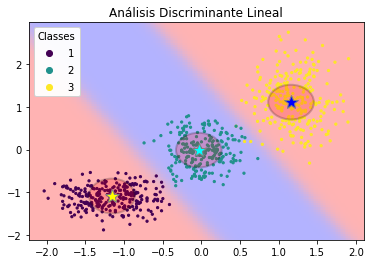

<Figure size 1440x720 with 0 Axes>

In [2377]:
## Se dibuja diagrama de dispersión con la separación por hiperplanos y el intervalo de confianza al 95%
color1=(0.69411766529083252, 0.3490196168422699, 0.15686275064945221, 1.0)
color2=(0.65098041296005249, 0.80784314870834351, 0.89019608497619629, 1.0)
color3=(0.6, 0.70784314870834351, 0.39019608497619629, 1.0)
colormap = np.array([color1,color2])

fig, ax = plt.subplots()
scatter = ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=5)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")

ax.add_artist(legend1)

plt.title("Análisis Discriminante Lineal")

# means
listcolor=["yellow","cyan","blue"]
for i in range(len(LDA_model_default.means_)):
    plt.plot(LDA_model_default.means_[i][0], LDA_model_default.means_[i][1],
    "*", color=listcolor[i], markersize=15, markeredgecolor="grey",)

nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = LDA_model_default.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0)

for i in range(len(LDA_model_default.means_)):
    ell=plot_ellipse(LDA_model_default.means_[i],LDA_model_default.covariance_,"red")
    ax.add_patch(ell)
plt.figure(figsize=(20,10))

plt.show()

Matriz de confusión, sin normalización
[[228   3   0]
 [  1 269   1]
 [  0   2 246]]
Matriz de confusión normalizada
[[0.99 0.01 0.  ]
 [0.   0.99 0.  ]
 [0.   0.01 0.99]]


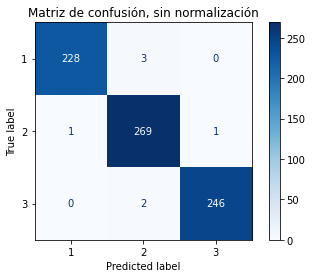

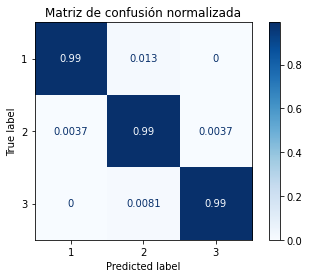

In [2378]:
np.set_printoptions(precision=2)

# Grafica matriz de confusión no normalizada
titles_options = [
    ("Matriz de confusión, sin normalización", None),
    ("Matriz de confusión normalizada", "true"),]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(LDA_model_default, 
           X_test, y_test, display_labels=["1","2","3"],
           cmap=plt.cm.Blues, normalize=normalize,)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()

Ahora, aplicamos QDA a los datos 

In [2379]:
QDA_model_default = QuadraticDiscriminantAnalysis(store_covariance=True)
QDA_model_default.fit(X_test, y_test)
y_pred_QDA_default = QDA_model_default.predict(X_test)
y_pred_QDA_default.tofile('predictionQDA.csv',sep=',')
score = QDA_model_default.score(X_test, y_test)
parametros = QDA_model_default.get_params(deep=False)
print(score)

0.9933333333333333


[[0.13 0.01]
 [0.01 0.06]]
[[ 0.07 -0.  ]
 [-0.    0.12]]
[[ 0.07 -0.  ]
 [-0.    0.31]]


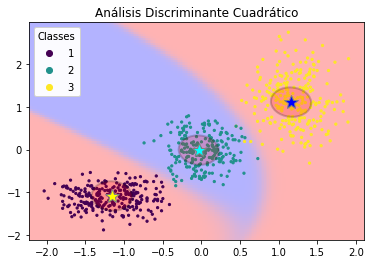

In [2380]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=5)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")

ax.add_artist(legend1)

plt.title("Análisis Discriminante Cuadrático")
# means
listcolor=["yellow","cyan","blue"]
for i in range(len(QDA_model_default.means_)):
    plt.plot(QDA_model_default.means_[i][0], QDA_model_default.means_[i][1],
    "*", color=listcolor[i], markersize=15, markeredgecolor="grey",)
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = QDA_model_default.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0)

for i in range(len(QDA_model_default.means_)):
    print(QDA_model_default.covariance_ [i])
    ell=plot_ellipse(QDA_model_default.means_[i],QDA_model_default.covariance_[1],"red")
    ax.add_patch(ell)
plt.show()

Matriz de confusión, sin normalización
[[230   1   0]
 [  2 268   1]
 [  0   1 247]]
Matriz de confusión normalizada
[[1.   0.   0.  ]
 [0.01 0.99 0.  ]
 [0.   0.   1.  ]]


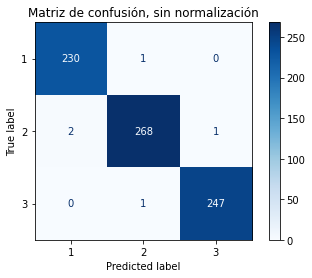

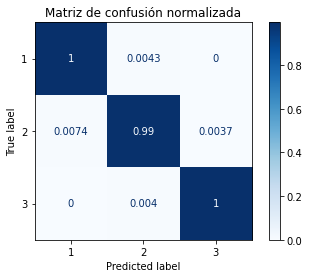

In [2381]:
np.set_printoptions(precision=2)

# Grafica matriz de confusión no normalizada
titles_options = [
    ("Matriz de confusión, sin normalización", None),
    ("Matriz de confusión normalizada", "true"),]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(QDA_model_default, 
           X_test, y_test, display_labels=["1","2","3"],
           cmap=plt.cm.Blues, normalize=normalize,)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()

### Regresión logística aplicada a clasificación de regiones de consumo de electricidad.





In [2382]:
## Procesamos datos
df = pd.read_csv('r_Regiones_100s_train.csv')
df=df.assign(const=1)
dfy = df['Clase'] 
dfx = df[['GenTer','GenHid','GenRE','GenNP','Demanda','Perdidas','PrecioMarginal']]  ## Predictors
X = dfx.to_numpy() 
## X = sm.add_constant(X) ## para agregar una constante en uno
y = dfy.to_numpy()

In [2383]:
## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.70, random_state = 5)

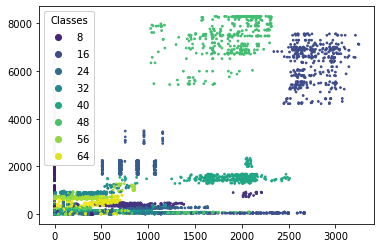

In [2384]:
fig, ax = plt.subplots()
scatter = ax.scatter(X_train[:,0], X_train[:,4], c=y_train, s=3)
legend1 = ax.legend(*scatter.legend_elements(),loc="upper left",title="Classes")
ax.add_artist(legend1)
plt.show()

In [2385]:
reg = ols('GenTer~GenHid+GenRE+GenNP+Demanda+Perdidas+PrecioMarginal',data=df).fit()
aov = sm.stats.anova_lm(reg,type=2) # Type 2 Anova DataFrame
print(aov)

                     df        sum_sq       mean_sq             F        PR(>F)
GenHid              1.0  1.447110e+07  1.447110e+07     70.167814  5.518693e-17
GenRE               1.0  2.544945e+09  2.544945e+09  12339.991992  0.000000e+00
GenNP               1.0  1.022426e+09  1.022426e+09   4957.566027  0.000000e+00
Demanda             1.0  7.146483e+09  7.146483e+09  34652.045727  0.000000e+00
Perdidas            1.0  1.270280e+09  1.270280e+09   6159.367386  0.000000e+00
PrecioMarginal      1.0  1.460320e+07  1.460320e+07     70.808371  3.989542e-17
Residual        96473.0  1.989616e+10  2.062355e+05           NaN           NaN


In [2386]:
LDA_model_default = LinearDiscriminantAnalysis()
LDA_model_default.fit(X_test, y_test)
y_pred_LDA_default = LDA_model_default.predict(X_test)
print(y_pred_LDA_default)
score  = LDA_model_default.score(X_test, y_test)
params = LDA_model_default.get_params(deep=False)
print(score)

[44 44 29 ... 65  8 16]
0.576048329779673


In [2387]:
QDA_model_default = QuadraticDiscriminantAnalysis()
QDA_model_default.fit(X_test, y_test)
y_pred_QDA_default = QDA_model_default.predict(X_test)
print(y_pred_QDA_default)
score  = QDA_model_default.score(X_test, y_test)
params = QDA_model_default.get_params(deep=False)
print(score)

[1 1 1 ... 1 1 1]
0.014895759298744373


Matriz de confusión, sin normalización
[[ 534    0    0 ...    0   59    0]
 [   0  999    0 ...    0    0    0]
 [   0    0 1044 ...    0    0    0]
 ...
 [   0    0    0 ...  909   15    0]
 [  17    0    0 ...    0  147    0]
 [   0    0    0 ...  169    0  741]]
Matriz de confusión normalizada
[[0.53 0.   0.   ... 0.   0.06 0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.9  0.01 0.  ]
 [0.02 0.   0.   ... 0.   0.15 0.  ]
 [0.   0.   0.   ... 0.17 0.   0.73]]


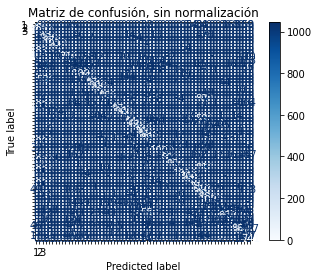

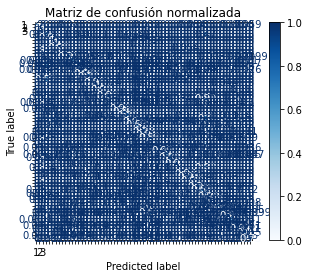

In [2364]:
np.set_printoptions(precision=2)

# Grafica matriz de confusión no normalizada
titles_options = [
    ("Matriz de confusión, sin normalización", None),
    ("Matriz de confusión normalizada", "true"),]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(LDA_model_default, 
           X_test, y_test, display_labels=["1","2","3"],
           cmap=plt.cm.Blues, normalize=normalize,)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()

## Ligas relacionadas

1. [Ejemplo de grafica de LDA Y QDA de scikit-learn.org ](https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html)  
2.  [Análisis Discriminante Lineal y Cuadrático de scikit-learn.org](https://scikit-learn.org/stable/modules/lda_qda.html) 
3. [Análisis Discriminante Lineal y Cuadrático de datasklr.com](https://www.datasklr.com/select-classification-methods/linear-and-quadratic-discriminant-analysis)
4. [Regresión logística usando Python (scikit-learn)
](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a)
5. [Cómo realizar análisis de covarianza (ANCOVA) en Python](https://www.youtube.com/watch?v=aJcIMwVOLeA)
6. [Cómo realizar una Matriz de confusión con Matplotlib](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html?highlight=confusion%20matrix)


